<div class="alert alert-warning">
<b>Reviewer's comment V2</b>
  
You did a great job fixing the problems, but I noticed one more that I missed during the first review. I'm really sorry about that, but it's a pretty important point.
  
</div>

<div class="alert alert-info">
<b>Student's comment v.2:</b><br>
Not a problem whatsoever. <br>
In fact, thank you for pointing out the mistake, I think it's very important. Updated.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
Ok, cool! Thank you for taking the time to improve the project. It is accepted now. Keep up the good work on the next sprint! :)
  
</div>

**Review**
  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! Clearly, you put a lot of effort into the project, and you did a great job overall! However there are some small problems that need to be fixed before the project can be accepted. It should be pretty straightforward to fix them though!

In [1]:
!pip install -q --user --upgrade pandas matplotlib seaborn sklearn scikit-learn

In [2]:
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from time import perf_counter as timer
from pprint import pprint
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import get_scorer, make_scorer, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingRandomSearchCV

In [3]:
pd.options.mode.chained_assignment = None
plt.rcParams["figure.figsize"] = (13, 7)

In [4]:
random_state = 123

# Customers churn classification
#### \- comissioned by: Beta Bank
***

Each month, customers are leaving the bank, little by little.  
We need to predict whether a customer is likely to leave,  
to be able to further apply target marketing and attempt to preserve those customers.

\* target metric for this exercise: F1 score >= 0.59

<br>

## Table of Contents
- [Utility functions](#Utility-functions)
- [Load dataset](#Load-dataset)
    - [Optimize dataframe](#Optimize-dataframe)
    - [Split data](#Split-data)
- [Preprocessing](#Preprocessing)
    - [Analysis of features by type](#Analysis-of-features-by-type)
    - [Missing values](#Missing-values)
    - [Outliers](#Outliers)
    - [Standardization](#Standardization)
    - [Categorical encoding](#Categorical-encoding)
    - [Target class](#Target-class)
- [Models](#Models)
    - [Dummy model](#Dummy-model)
    - [Model metrics - imbalanced data](#Model-metrics---imbalanced-data)
    - [Hyperparameters tuning](#Hyperparameters-tuning)
    - [Model testing](#Model-testing)
    - [Best model test scores](#Best-model-test-scores)
- [Conclusions](#Conclusions)

<br>

### Utility functions
***
[back](#Table-of-Contents)

In [5]:
def find_file(filename):
    """Returns file path under /datasets directory, if exists, otherwise uses local dir"""
    
    filepath = f'/datasets/{filename}'
    if not os.path.isfile(filepath):
        filepath = filename
        
    return filepath

# find_file(filename)

In [6]:
def hide_warnings(func):
    """Hide warnings"""
    
    def wrapper(*args, **kwargs):
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            
            return func(*args, **kwargs)
        
    return wrapper

# warnings.warn('warning')
# hide_warnings(lambda:warnings.warn('hidden'))()

In [7]:
# PEP616 -- String methods to remove prefixes and suffixes
# https://www.python.org/dev/peps/pep-0616/

def removesuffix(self, suffix):
    # suffix='' should not call self[:-0].
    if suffix and self.endswith(suffix):
        return self[:-len(suffix)]
    else:
        return self[:]
    
# removesuffix('abc', 'c')

In [8]:
def time_wrap(func):
    """Measures execution time"""
    
    def wrapper(*args, **kwargs):
        start = timer()
        out = func(*args, **kwargs)
        return timer()-start, out
        
    return wrapper

# time_wrap(lambda x:(x+1,x+2))(2)

<br>

## Load dataset
***
[back](#Table-of-Contents)

- [Optimize dataframe](#Optimize-dataframe)
- [Split data](#Split-data)

Features

    RowNumber — data string index
    CustomerId — unique customer identifier
    Surname — surname
    CreditScore — credit score
    Geography — country of residence
    Gender — gender
    Age — age
    Tenure — period of maturation for a customer’s fixed deposit (years)
    Balance — account balance
    NumOfProducts — number of banking products used by the customer
    HasCrCard — customer has a credit card
    IsActiveMember — customer’s activeness
    EstimatedSalary — estimated salary

Target

    Exited — сustomer has left

In [9]:
filename = 'Churn.csv'

In [10]:
def preview(filename, n=2):
    """Prints file's metadata, and first n lines"""
    
    !file "$filename"
    
    size = !du -h "$filename"
    size = size[0].split()[0]
    
    lines = !wc -l "$filename"
    lines = lines[0].split()[0]
    
    info = {'size': size, 'lines': lines}
    print('\n'.join(f'{k:<{len(filename)+2}}{v}' for k,v in info.items()))
    print()
    !head -n"$n" "$filename"
    
# preview(filename)

In [11]:
filename = find_file(filename)

In [12]:
preview(filename)

Churn.csv: ASCII text, with CRLF line terminators
size       696K
lines      10001

RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1,15634602,Hargrave,619,France,Female,42,2.0,0.0,1,1,1,101348.88,1


In [13]:
df = pd.read_csv(filename)

In [14]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [15]:
df.shape

(10000, 14)

In [16]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 2.6 MB


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

### Optimize dataframe
[up](#Load-dataset)

In [17]:
def optimize_dtypes(df):
    """Downcast numeric dtypes"""
    
    return pd.concat([
        df.select_dtypes('integer').apply(lambda x:pd.to_numeric(x, downcast='signed')),
        df.select_dtypes('float').apply(lambda x:pd.to_numeric(x, downcast='float')),
        df.select_dtypes('object')
    ], axis=1).reindex(df.columns, axis=1)

# optimize_dtypes(df).info(memory_usage='deep')
# optimize_dtypes(df).head()
# df[optimize_dtypes(df) != df]

In [18]:
df_original = df

'RowNumber', 'CustomerId' and 'Surname' are for identification purposes - unnecessary for our classification task.

In [19]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [20]:
df = optimize_dtypes(df)

In [21]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int16  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int8   
 4   Tenure           9091 non-null   float32
 5   Balance          10000 non-null  float32
 6   NumOfProducts    10000 non-null  int8   
 7   HasCrCard        10000 non-null  int8   
 8   IsActiveMember   10000 non-null  int8   
 9   EstimatedSalary  10000 non-null  float32
 10  Exited           10000 non-null  int8   
dtypes: float32(3), int16(1), int8(5), object(2)
memory usage: 1.4 MB


### Split data
[up](#Load-dataset)

We will split our data into 3 parts:  
training set, validation set, and test set.  
training will be used to fit the models, validation to tinker with parameters, and test for the final verdict.

Using stratify=target to make sure the target class ratio is kept the same between the different sets.

In [22]:
target = df['Exited']
features = df.drop('Exited', axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=random_state)

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      stratify=y_train,
                                                      random_state=random_state)

In [25]:
X_train.shape, y_train.shape

((6000, 10), (6000,))

In [26]:
X_valid.shape, y_valid.shape

((2000, 10), (2000,))

In [27]:
X_test.shape, y_test.shape

((2000, 10), (2000,))

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train, validation and test. The proportions are reasonable.

</div>

<br>

## Preprocessing
***
[back](#Table-of-Contents)

- [Analysis of features by type](#Analysis-of-features-by-type)
- [Missing values](#Missing-values)
- [Outliers](#Outliers)
- [Standardization](#Standardization)
- [Categorical encoding](#Categorical-encoding)
- [Target class](#Target-class)

In [28]:
def calculate_descriptive_stats(series):
    """Returns a Tuple: (lower extreme, upper extreme, IQR, Q1, Q3)"""
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    
    limits = [
        max(q1 - (1.5 * iqr), series.min()),
        min(q3 + (1.5 * iqr), series.max())]
    
    return limits[0], limits[1], iqr, q1, q3

In [29]:
def outliers_report(df):
    """Generates a report. For each column, states extremes and number of outliers."""
    
    for column in df.columns:
        series = df[column]
        lower_extreme, upper_extreme, _, _, _ = calculate_descriptive_stats(series)
        outliers = series[(series < lower_extreme) | (series > upper_extreme)]
        print(f'{series.name} outliers: {len(outliers)} ({len(outliers)/len(series):.2%})')
        print(f'lower extreme: {lower_extreme}  upper extreme: {upper_extreme}')
        print()
        # print(outliers, '\n')

In [30]:
def outliers_mask(df):
    """Returns a mask (True/False DataFrame), True for outlier."""
    
    mask = []
    
    for column in df.columns:
        series = df[column]
        lower_extreme, upper_extreme, _, _, _ = calculate_descriptive_stats(series)
        mask.append((df[column] > upper_extreme) | (df[column] < lower_extreme))
        
    return pd.concat(mask, axis=1)

In [31]:
X_train.describe(include='O')

,Geography,Gender
count,6000,6000
unique,3,2
top,France,Male
freq,3027,3304


In [32]:
X_train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,6000.000000,6000.000000,5451.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,650.377000,38.882333,4.988442,75571.273438,1.527167,0.705667,0.517000,99893.187500
std,96.156254,10.306512,2.893595,62392.722656,0.575602,0.455780,0.499753,57509.679688
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,91.750000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.000000,0.000000,50895.310547
50%,651.000000,37.000000,5.000000,96647.175781,1.000000,1.000000,1.000000,99812.152344
75%,717.250000,44.000000,7.000000,126995.585938,2.000000,1.000000,1.000000,149079.750000
max,850.000000,92.000000,10.000000,238387.562500,4.000000,1.000000,1.000000,199992.484375


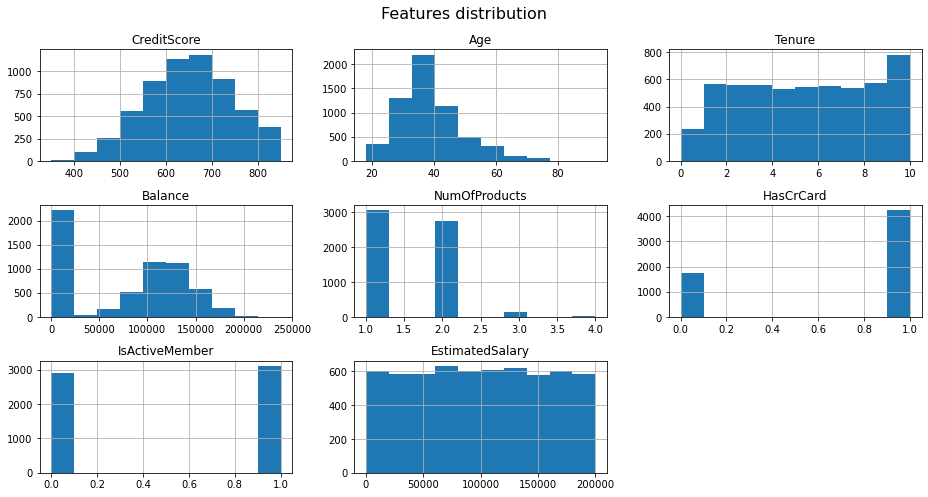

In [33]:
X_train.select_dtypes('number').hist()
plt.suptitle('Features distribution', fontsize=16)
plt.tight_layout()

### Analysis of features by type
[up](#Preprocessing)

In [34]:
categorical_columns = ['Geography', 'Gender']

In [35]:
boolean_columns = ['IsActiveMember', 'HasCrCard']

In [36]:
numerical_columns = features.columns.symmetric_difference(categorical_columns + boolean_columns).tolist()
numerical_columns

['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'NumOfProducts', 'Tenure']

In [37]:
print('Variable types\n',
      'Categorical:\n  {}'.format('\n  '.join(f for f in categorical_columns)), '',
      'Boolean:\n  {}'.format('\n  '.join(f for f in boolean_columns)), '',
      'Numerical:\n  {}'.format('\n  '.join(f for f in numerical_columns)), '',
      f'Total features: {len(categorical_columns + boolean_columns + numerical_columns)}', sep='\n')

Variable types

Categorical:
  Geography
  Gender

Boolean:
  IsActiveMember
  HasCrCard

Numerical:
  Age
  Balance
  CreditScore
  EstimatedSalary
  NumOfProducts
  Tenure

Total features: 10


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

- `Tenure` is a numerical feature, not categorical. It represents how long someone has been the client of the bank.
- `NumOfProducts` is literally the *number* of bank products a customer uses, so it's a numerical feature too :)

</div>

<div class="alert alert-info">
<b>Student's comment v.1:</b><br>
    I see what you mean, I have thought about it the wrong way - updated.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
Ok, by the way boolean features are equivalent to categorical features with two possible values.
  
</div>

In [38]:
def preprocess_data(*data, 
                    numerical_cols=numerical_columns,
                    categorical_cols=categorical_columns,
                    scaler=None,
                    ohe=None,
                    refit=False):
    
    """Feature standardization & One-Hot encoding"""
    
    assert data and len(data) > 0, "'data' must contain at least one element"
        
    if scaler == None:
        scaler = StandardScaler().fit(data[0][numerical_cols])
    
    if ohe == None:
        ohe = OneHotEncoder(drop='first', dtype='int8').fit(data[0][categorical_cols])
        
    if refit:
        scaler.fit(data[0][numerical_cols])
        ohe.fit(data[0][categorical_cols])
    
    def process(X):
        data_scaled = pd.DataFrame(data=scaler.transform(X[numerical_cols]),
                                   columns=numerical_cols,
                                   index=X.index)
        data_ohe = pd.DataFrame(data=ohe.transform(X[categorical_cols]).toarray(),
                                columns=ohe.get_feature_names(categorical_cols),
                                index=X.index)
        
        remaining = X[X.columns.symmetric_difference(numerical_cols + categorical_cols)]
        
        return pd.concat([
            data_scaled,
            data_ohe,
            remaining
        ], axis=1)
    
    return scaler, ohe, *[process(d) for d in data]

# preprocess_data(X_train, X_test, categorical_cols=['Gender', 'Geography'])

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

- If we use different scalers for the train set and the test set, then, if we're unlucky with the split, the data will not be scaled appropriately. Consider an extreme example: suppose feature X in the train set is a constant 0, but the same feature in the test set is a constant 100000, then after fitting the scaler on the train set and applying it, feature X will remain 0 in the transformed train set, but as we use a different scaler for the test set, it will become 0 in the transformed test set (remember that standard scaling is just subtracting the mean and dividing by standard deviation of the data that the scaler is fit on). So while the data is extremely different in the original train and test set, it becomes identical after the transformation. Clearly, this makes no sense. So, the correct approach is to fit the scaler using the train set, and the use it to transform both the train and the test set.
    
- Similar problem with using `pd.get_dummies` separately on train and test: we might end up with different columns in the two sets if we're unlucky. The correct approach is to use [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) fit using the train set. 
    
</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

By the way, there is a more convenient way to apply transformers before a model in scikit-learn: [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). And to apply different transormations to different columns (for example encoder for categorical and scaler for numerical) there's [ColumnTransformer](https://scikit-learn.org/stable/modules/compose.html#column-transformer).

</div>

<div class="alert alert-info">
<b>Student's comment v.1:</b><br>
update above.  
  
I am not sure how to reconcile GridSearchCV with pipelines, so for this project I will not use it. <br>
I'll make sure to read up on it so I can utilize it for the next project though, thanks.
</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>
  
Ok, no problem! The beauty of pipelines is that they just replace the model, so instead of running

```python
GridSearchCV(model, params)
```
you just do
    
```python
GridSearchCV(pipeline, params)
```
    
And in `params` you just need to prepend the parameter names with the model name in the pipeline. For example if your pipeline is 
    
```python
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('rf', RandomForestClassifier())
    ]) 
```
Then you can set the parameters of random forest as follows:

```python
params = {
        'rf__criterion': ['gini', 'entropy'],
        'rf__max_depth': [10, 20, 30, 50, None],
        'rf__min_samples_split': [2, 4, 8],
        'rf__min_samples_leaf': [1, 2, 3],
        'rf__n_estimators': [100, 110, 120, 130],
    }   
```
    
In fact, this is the proper way to do scaling, imputation and other similar transformation for cross-validation, because otherwise you'll have the same problem as with applying it to the whole dataset before separating it into train and test (so the hyperparameters selected by GridSearchCV might be suboptimal).
  
</div>

### Missing values
[up](#Preprocessing)

In [39]:
X_train.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             549
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
dtype: int64

In [40]:
(X_train.isna().sum() / X_train.count())['Tenure']

0.10071546505228399

In [41]:
X_train.corr()['Tenure']

CreditScore        0.001558
Age               -0.024293
Tenure             1.000000
Balance            0.000852
NumOfProducts      0.015712
HasCrCard          0.010756
IsActiveMember    -0.029238
EstimatedSalary    0.018051
Name: Tenure, dtype: float64

'Tenure' has a lot (~10%) of missing values.

In [42]:
# X_train.loc[:, 'Tenure'] = X_train['Tenure'].fillna(X_train['Tenure'].median())

~We will use one-hot encoding later on, which can deal with missing values.~

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

As mentioned earlier, `Tenure` is a numerical feature.

</div>

Since Tenure is a numerical feature, we will fill in the missing values with representative values (median).

In [43]:
tenure_median = features['Tenure'].median()

In [44]:
X_train['Tenure'].fillna(tenure_median, inplace=True)

In [45]:
X_train.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [46]:
X_valid['Tenure'].fillna(tenure_median, inplace=True)

In [47]:
X_valid.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

Missing values have been successfully filled.

### Outliers
[up](#Preprocessing)

Checking for outliers of numerical variables:

In [48]:
outliers_report(X_train[numerical_columns])

Age outliers: 199 (3.32%)
lower extreme: 18  upper extreme: 62.0

Balance outliers: 0 (0.00%)
lower extreme: 0.0  upper extreme: 238387.5625

CreditScore outliers: 12 (0.20%)
lower extreme: 384.125  upper extreme: 850

EstimatedSalary outliers: 0 (0.00%)
lower extreme: 91.75  upper extreme: 199992.484375

NumOfProducts outliers: 30 (0.50%)
lower extreme: 1  upper extreme: 3.5

Tenure outliers: 0 (0.00%)
lower extreme: 0.0  upper extreme: 10.0



In [49]:
mask = outliers_mask(X_train[numerical_columns])
mask.sum()

Age                199
Balance              0
CreditScore         12
EstimatedSalary      0
NumOfProducts       30
Tenure               0
dtype: int64

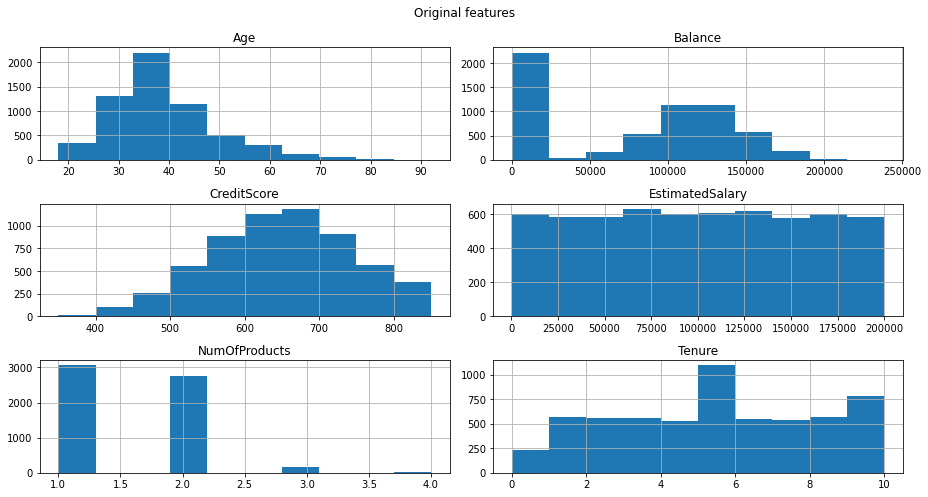

In [50]:
X_train[numerical_columns].hist()
plt.suptitle('Original features')
plt.tight_layout()

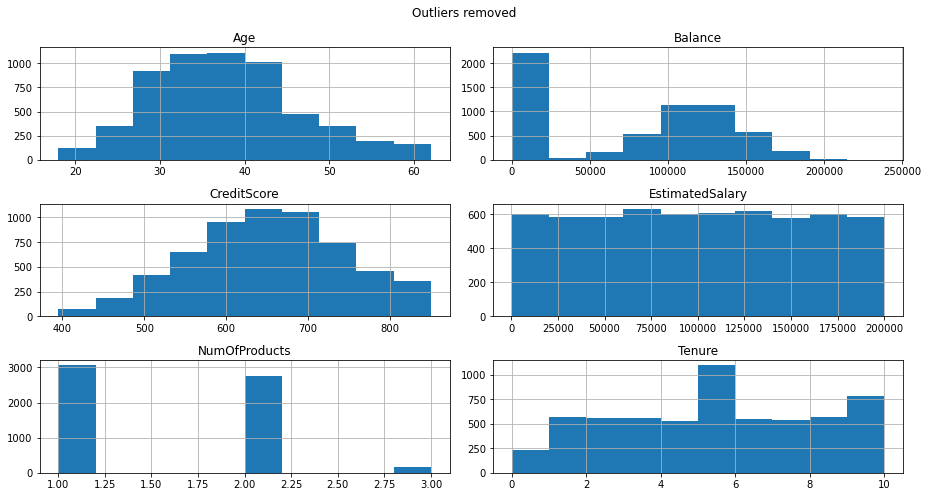

In [51]:
X_train[numerical_columns].mask(mask).hist()
plt.suptitle('Outliers removed')
plt.tight_layout()

Shape of the distribution changes drastically for the 'Age' column, but at the expense of losing a substantial range of values.  
Also NumOfProducts has lost a a single value (out of 4 possible values), which is 25% of its range.

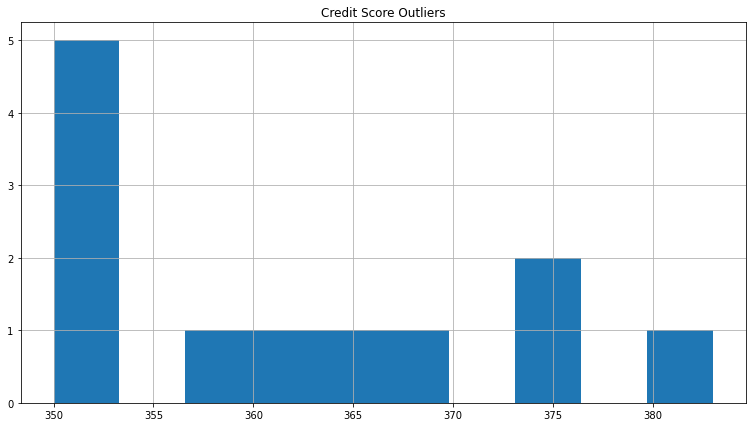

In [52]:
X_train[numerical_columns].mask(~mask)['CreditScore'].hist()
plt.title('Credit Score Outliers');

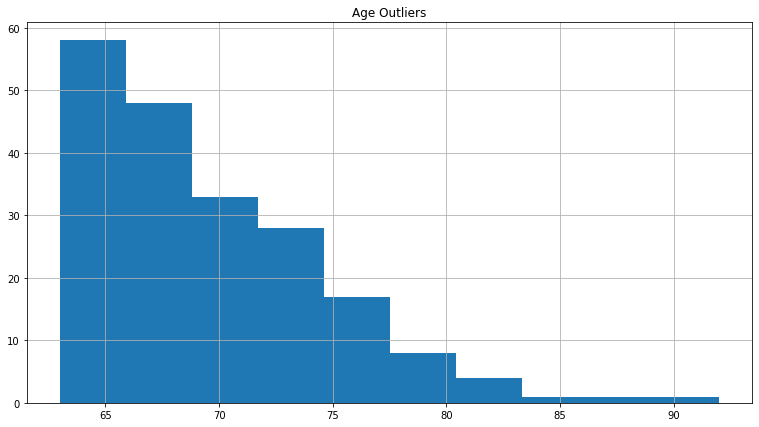

In [53]:
X_train[numerical_columns].mask(~mask)['Age'].hist();
plt.title('Age Outliers');

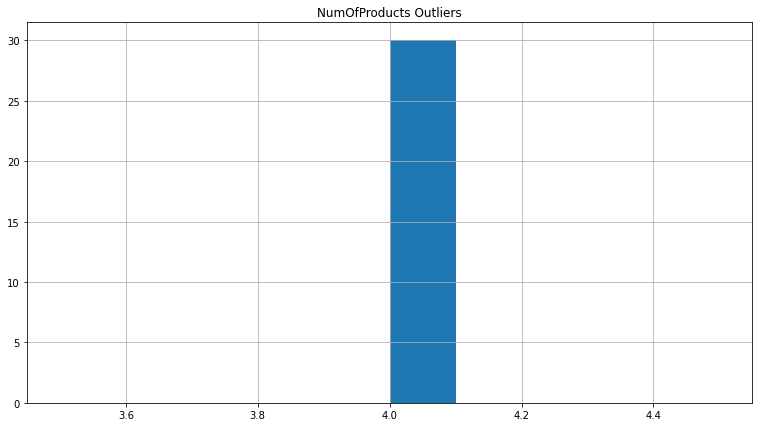

In [54]:
X_train[numerical_columns].mask(~mask)['NumOfProducts'].hist();
plt.title('NumOfProducts Outliers');

Values deemed 'outliers' by our algorithm are valid values,  
and are important for the training of ML models.

Leaving intact.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Yeah, well, what we consider outliers entirely depends on the technique we use to detect outliers :)

</div>

### Standardization
[up](#Preprocessing)

For our models to be trained correctly, the numerical data should be on a uniform scale.  
We will utilize Standard Scaler, which removes the mean and scales to unit variance.

In [55]:
numerical_columns

['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'NumOfProducts', 'Tenure']

In [56]:
scaler = StandardScaler()

In [57]:
scaled_numerical = pd.DataFrame(
    scaler.fit_transform(X_train[numerical_columns]),
    columns=numerical_columns,
    index=X_train[numerical_columns].index)

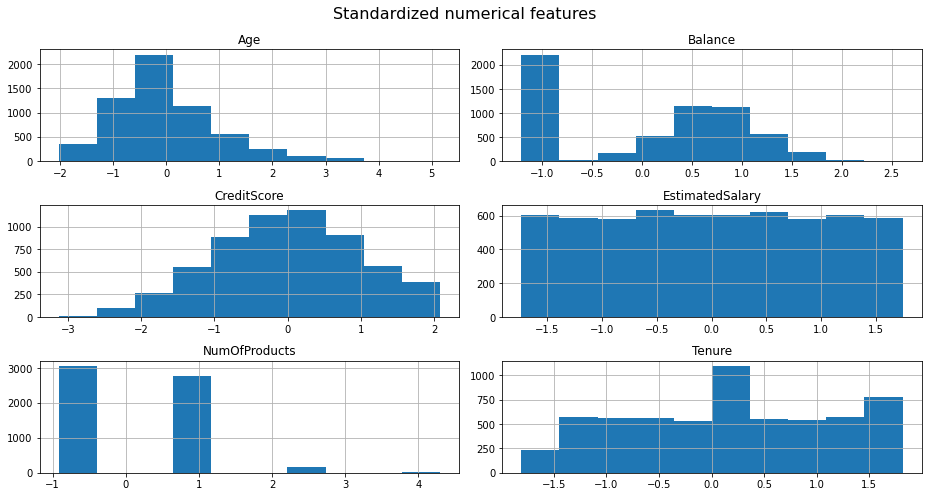

In [58]:
scaled_numerical.hist()
plt.suptitle('Standardized numerical features', fontsize=16)
plt.tight_layout()

### Categorical encoding
[up](#Preprocessing)

Most ML models of sklearn library are not accepting string values - only numerical values.  
For this reason, we will have to encode our categorical features as numerical.

In [59]:
categorical_columns

['Geography', 'Gender']

For ordinal categories, where order matters, we would use label encoding.  
For nominal categories, will use One-Hot encoding.

Since order should not matter for either 'Geography' nor 'Gender', we will use One-Hot encoding on both.

\* 'IsActiveMember' and 'HasCrCard' are already in the wanted form (One-Hot Encoding).

In [60]:
ohe_categorical = pd.get_dummies(X_train[categorical_columns]
                         .astype('str'),
                         drop_first=True)
ohe_categorical.head()

,Geography_Germany,Geography_Spain,Gender_Male
4053,0,1,1
9797,0,1,1
4101,0,1,0
8920,0,0,0
2353,0,0,0


In [61]:
# extracted to a function, left as reference for review.
# 
# X_train_scaled = pd.concat([
#     scaled_numerical,
#     ohe_categorical,
#     X_train[boolean_columns],
# ], axis=1)

In [62]:
X_train_old = X_train
X_valid_old = X_valid

In [63]:
scaler, ohe, X_train, X_valid = preprocess_data(X_train, X_valid)

In [64]:
X_train.columns

Index(['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'NumOfProducts',
       'Tenure', 'Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'HasCrCard', 'IsActiveMember'],
      dtype='object')

In [65]:
X_train.shape

(6000, 11)

In [66]:
X_valid.columns

Index(['Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'NumOfProducts',
       'Tenure', 'Geography_Germany', 'Geography_Spain', 'Gender_Male',
       'HasCrCard', 'IsActiveMember'],
      dtype='object')

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, I can see you at least compared the columns of train and validation sets after the preprocessing!

</div>

In [67]:
X_valid.shape

(2000, 11)

In [68]:
train_valid = X_train, X_valid, y_train, y_valid

### Target class
[up](#Preprocessing)

In [69]:
target.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

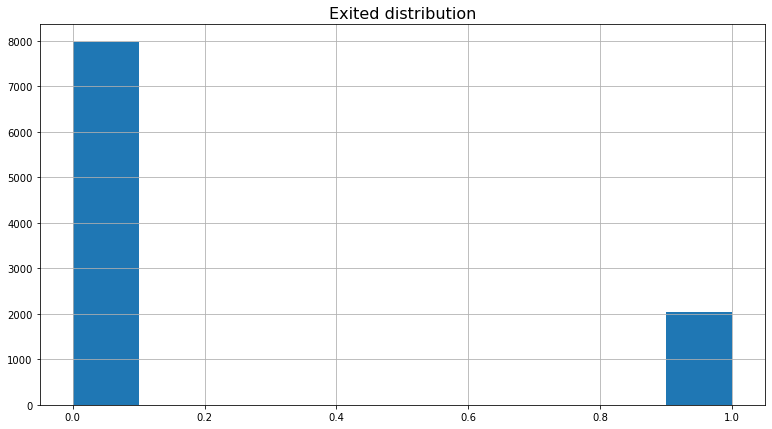

In [70]:
target.hist()
plt.title('Exited distribution', fontsize=16);

Target class is clearly imbalanced (4:1).

<div class="alert alert-success">
<b>Reviewer's comment</b>

Class imbalance was noted

</div>

<br>

## Models
***
[back](#Table-of-Contents)

- [Dummy model](#Dummy-model)
- [Model metrics - imbalanced data](#Model-metrics---imbalanced-data)
- [Hyperparameters tuning](#Hyperparameters-tuning)
- [Model testing](#Model-testing)
- [Best model test scores](#Best-model-test-scores)

In [71]:
# print(sorted(sklearn.metrics.SCORERS.keys()))

In [72]:
scorers = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', make_scorer(matthews_corrcoef)]

In [73]:
def get_scorer_name(self):
    """Remove '_score' suffix from scorer's name"""
    
    if isinstance(self, str):
        return removesuffix(self, '_score')
    elif callable(self):
        return removesuffix(self._score_func.__name__, '_score')
    
# get_scorer_name(scorers[-1])

In [74]:
def get_score(scorer, y_true, y_pred=None, y_proba=None):
    """"""
    
    if isinstance(scorer, str):
        scorer = get_scorer(scorer)

    if scorer == None:
        scorer = getattr(model, 'scoring', None)

    if scorer != None:
        score_type = get_scorer_name(scorer)

        if score_type == 'roc_auc':
            score = scorer._score_func(y_true, y_proba)
        else:
            score = scorer._score_func(y_true, y_pred)
    else:
        score_type, score = 'score', model.score(y_true, y_pred)

    return score_type, score

In [75]:
@hide_warnings
def generate_scores_report(model, scorers, y_true, y_pred, y_proba, hide=False):
    """Generates a scores report, with timing"""
    
    _get_score = time_wrap(lambda scorer:get_score(scorer, y_true, y_pred, y_proba))
    
    report = {get_scorer_name(t): [score, time] for time, (t, score) in map(lambda x:_get_score(x), scorers)}
    
    if not hide:
        print('scores:')
        print('\n'.join([f'  {f"{k}:":<20}{v[0]:<25.4f}{f"time: {v[1]:.4f}":>10}' for k,v in report.items()]))
    
    scores = {k: v[0] for k, v in report.items()}
    times = {k: v[1] for k, v in report.items()}
    
    report = {
        'scores': scores,
        'times': times
    }
    
    return report

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

ROC-AUC is calculated incorrectly. It needs a different input than other scoring functions you use. Remember that the ROC curve is constructed by varying the threshold of assigning the positive class between 0 and 1. If we use binary predictions (method `predict`), there are only three distinct thresholds: 0, 1, and any number between 0 and 1. For a correct value of ROC-AUC we need to use probabilities (method `predict_proba`).

</div>

<div class="alert alert-info">
<b>Student's comment v.1:</b><br>
    😬 Bad oversight on my part - updated.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
Don't worry about it too much! :)
  
</div>

In [76]:
def get_scores(model, *data, scorers=scorers, hide=False):
    """Utility wrapper for generate_scores_report function"""
    
    X_train, X_test, y_train, y_test = data
    
    start_time = timer()
    model.fit(X_train, y_train)
    train_time = timer() - start_time
    
    start_time = timer()
    y_pred = model.predict(X_test)
    predict_time = timer() - start_time
    
    y_proba = model.predict_proba(X_test)[:, 1]
    
    if not hide:
        print(f'{f"train time:":<15} {train_time:.4f}')
        print(f'{f"predict time:":<15} {predict_time:.4f}')
    
    report = generate_scores_report(model, scorers, y_test, y_pred, y_proba, hide=hide)
    report['confusion'] = confusion_matrix(y_test, y_pred)
    report['times'] = {
        'fit': train_time,
        'predict': predict_time,
        'score': report['times']
    }
    
    return report

In [77]:
def report_to_df(report):
    """Converts report dictionary to a readable DataFrame."""
    
    return (pd.DataFrame({k: v['scores'] 
                          for k, v in report.items()}).rename_axis('scores', axis=0).T,
            pd.DataFrame({k: pd.json_normalize(v['times'], sep='_').squeeze() 
                          for k, v in report.items()}
                        ).rename_axis('time (s)', axis=0).T[['fit', 'predict']])

In [78]:
def compare_models(models, *data, display=False):
    """Generates 2 dataframes: one for elapsed time (seconds), the other for scores."""
    
    reports = {model.__class__.__name__: get_scores(model, *data, hide=True)
               for model in models}

    # pprint(reports)
    if display:
        globals()['display'](*report_to_df(reports))
        
    return reports
        
# compare_models([dummy], X_train, X_valid, y_train, y_valid, display=True);

In [79]:
@hide_warnings
def halving_random(models, *data, cv_scoring='roc_auc', scorers=scorers, 
                   display=False, verbose=False, **kwargs):
    """Randomized search on hyper parameters (using HalvingRandomSearchCV)"""
    
    X_train, X_valid, y_train, y_valid = data
    X = pd.concat([X_train, X_valid])
    y = pd.concat([y_train, y_valid])
    
    reports = {}
    
    cv_scoring = get_scorer_name(cv_scoring)
    # scoring = { get_scorer_name(k): get_scorer(k) for k in scorers }
    # print(scoring, '\n')
            
    for model, params in models.items():
        model_name = model.__class__.__name__
        
        if params != None and len(params) > 0:
            rh = HalvingRandomSearchCV(model, params,
                                       n_jobs=-1,
                                       scoring=cv_scoring,
                                       refit=False,
                                       random_state=random_state, **kwargs).fit(X, y)
            
            cv_res = pd.DataFrame(rh.cv_results_)
            best = cv_res.iloc[rh.best_index_]
            # print(model_name, rh.best_score_, rh.best_params_)
            # print(cv_res.iloc[rh.best_index_])
            
            model.set_params(**best['params']).fit(X_train, y_train)
            predict_time, y_pred = time_wrap(lambda:model.predict(X_valid))()
            y_proba = model.predict_proba(X_valid)[:, 1]
            scores = generate_scores_report(model, scorers, y_valid, y_pred, y_proba, hide=True)['scores']
            # print(scores)
            
            reports[model_name] = {
                'model': model,
                'scores': scores,
                'times': {
                    'fit': best['mean_fit_time'],
                    'predict': predict_time
                }
            }
        else:
            reports[model_name] = get_scores(model, *data, hide=True)
            
        reports[model_name]['model'] = model
            
        if verbose:
            print(model)
            
    # pprint(reports)
    if display:
        globals()['display'](*report_to_df(reports))
        
    return reports

In [80]:
# # test function

# halving_random({
#     DummyClassifier(strategy='stratified', constant=1, random_state=random_state): None,
#     LogisticRegression(random_state=random_state): {
#         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#         'tol': [1e-1, 1e-2, 1e-3],
#         'C': [1, 1e-1, 1e-2]
#     }
# }, *train_valid, display=True);

### Dummy model
[up](#Models)

In [81]:
dummy = DummyClassifier(strategy='constant', constant=1, random_state=random_state)

In [82]:
get_scores(dummy, *train_valid)['confusion']

train time:     0.0011
predict time:   0.0004
scores:
  accuracy:           0.2035                   time: 0.0016
  precision:          0.2035                   time: 0.0020
  recall:             1.0000                   time: 0.0019
  f1:                 0.3382                   time: 0.0014
  roc_auc:            0.5000                   time: 0.0013
  matthews_corrcoef:  0.0000                   time: 0.0026


array([[   0, 1593],
       [   0,  407]])

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, we have a baseline!

</div>

<div class="alert alert-warning">
<b>Reviewer's comment</b>

- The scores report is not very readable: do we really need 19 digits after the decimal point? 
- 'stratified' strategy does not seem like the best possible baseline from DummyClassifier. I suggest trying other strategies and comparing the results.

</div>

<div class="alert alert-info">
<b>Student's comment v.1:</b><br>
    I thought that because our class is imbalanced, 'stratified' would yield best results? <br>
    Below I have tried to use different arguments for the strategy parameter, <br>
    but could not understand which is best suitable for our particular use case. <br>
    Can you please elaborate?
</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>
  
Well, the choice of a baseline to compare our other models to is pretty much arbitrary (so you can use whatever you'd like), but for a more meaningful comparison we'd like the baseline to be a simple model that still does something useful (measured by some metric). In this project our main metrics are F1 score and ROC-AUC. Based on these metrics, dummy models using strategies 'uniform' and 'constant 1' have better scores but are just as simple as the dummy model with 'stratified' strategy, thus provide a better baseline. As an analogy, which is more impressive: when I say I can jump higher than 1 cm or I can jump higher than 1 m?
  
</div>

<div class="alert alert-info">
<b>Student's comment v.2:</b><br>
Your update made it clearer, using 'constant' with constant=1 for highest baseline f1 and roc_auc.
</div>

In [83]:
get_scores(DummyClassifier(strategy='stratified', random_state=random_state),
           *train_valid)['confusion']

train time:     0.0011
predict time:   0.0013
scores:
  accuracy:           0.6590                   time: 0.0012
  precision:          0.1765                   time: 0.0021
  recall:             0.1843                   time: 0.0021
  f1:                 0.1803                   time: 0.0017
  roc_auc:            0.4823                   time: 0.0015
  matthews_corrcoef:  -0.0349                  time: 0.0034


array([[1243,  350],
       [ 332,   75]])

In [84]:
get_scores(DummyClassifier(strategy='most_frequent', random_state=random_state),
           *train_valid)['confusion']

train time:     0.0008
predict time:   0.0007
scores:
  accuracy:           0.7965                   time: 0.0009
  precision:          0.0000                   time: 0.0014
  recall:             0.0000                   time: 0.0014
  f1:                 0.0000                   time: 0.0017
  roc_auc:            0.5000                   time: 0.0014
  matthews_corrcoef:  0.0000                   time: 0.0022


array([[1593,    0],
       [ 407,    0]])

In [85]:
get_scores(DummyClassifier(strategy='prior', random_state=random_state),
           *train_valid)['confusion']

train time:     0.0012
predict time:   0.0008
scores:
  accuracy:           0.7965                   time: 0.0010
  precision:          0.0000                   time: 0.0014
  recall:             0.0000                   time: 0.0013
  f1:                 0.0000                   time: 0.0012
  roc_auc:            0.5000                   time: 0.0012
  matthews_corrcoef:  0.0000                   time: 0.0023


array([[1593,    0],
       [ 407,    0]])

In [86]:
get_scores(DummyClassifier(strategy='uniform', random_state=random_state),
           *train_valid)['confusion']

train time:     0.0009
predict time:   0.0006
scores:
  accuracy:           0.4860                   time: 0.0012
  precision:          0.1965                   time: 0.0015
  recall:             0.4939                   time: 0.0015
  f1:                 0.2811                   time: 0.0018
  roc_auc:            0.5000                   time: 0.0013
  matthews_corrcoef:  -0.0178                  time: 0.0032


array([[771, 822],
       [206, 201]])

In [87]:
get_scores(DummyClassifier(strategy='constant', constant=1, random_state=random_state),
           *train_valid)['confusion']

train time:     0.0011
predict time:   0.0004
scores:
  accuracy:           0.2035                   time: 0.0018
  precision:          0.2035                   time: 0.0020
  recall:             1.0000                   time: 0.0017
  f1:                 0.3382                   time: 0.0018
  roc_auc:            0.5000                   time: 0.0013
  matthews_corrcoef:  0.0000                   time: 0.0025


array([[   0, 1593],
       [   0,  407]])

### Model metrics - imbalanced data
[up](#Models)

To demonstrate the effects of class imbalance on our model,  
we will compare models' score before and after class imbalance is taken into account.

In [88]:
def get_class_ratio(y):
    """Returns binary class ratio (balance)."""
    
    return int(y.value_counts(normalize=True).to_frame().apply(lambda x:x[0]/x[1]).round())

In [89]:
def upsample(features, target, repeat, random_state=None):
    """Returns balanced (upsampled) samples."""
    
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]
    
    features_upsampled = pd.concat([features_zero] + [features_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)

    return shuffle(features_upsampled, target_upsampled, random_state=random_state)

# upsample(X_train, y_train, 4)[1].value_counts(normalize=True)

In [90]:
def downsample(features, target, fraction, random_state=None):
    """Returns balanced (downsampled) samples."""
    
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]

    features_downsampled = pd.concat(
        [features_zero.sample(frac=fraction, random_state=random_state)]
        + [features_one])
    target_downsampled = pd.concat(
        [target_zero.sample(frac=fraction, random_state=random_state)]
        + [target_one])

    return shuffle(features_downsampled, target_downsampled, random_state=random_state)

# downsample(X_train, y_train, 1/4)[1].value_counts(normalize=True)

In [91]:
def fit_score(model, *data, scoring='accuracy', balance=False, random_state=None):
    """
    Trains a model.
    
    params:
        - scoring: type of score. 'accuracy' by default.
        - balance: specify a balancing method to counteract target class imbalance. False by default.
    
    Returns model score (float).
    """
    
    X_train, X_test, y_train, y_test = data
    
    if balance == 'class_weight':
        model.set_params(class_weight='balanced')
    elif balance == 'upsample':
        X_train, y_train = upsample(X_train, y_train, get_class_ratio(y_train), random_state)
    elif balance == 'downsample':
        X_train, y_train = downsample(X_train, y_train, 1/get_class_ratio(y_train), random_state)
        
    model.set_params(random_state=random_state)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    scorer = get_scorer(scoring)
    return get_score(scorer, y_test, y_pred, y_proba)[1]

In [92]:
def balance_data_comparison(model, metrics=['f1', 'roc_auc'], random_state=None):
    """Compares different kinds of class balancing techniques"""
    
    return pd.DataFrame.from_dict(
        { metric: {
        balance: fit_score(model, *train_valid, scoring=metric, balance=balance, random_state=random_state)
        for balance in ['baseline', 'class_weight', 'upsample', 'downsample']
    } for metric in ['f1', 'roc_auc']}).rename_axis(model.__class__.__name__, axis=1)

# balance_data_comparison(LogisticRegression(random_state=random_state))

In [93]:
balance_data_comparison(LogisticRegression(), random_state=random_state)

LogisticRegression,f1,roc_auc
baseline,0.315972,0.768318
class_weight,0.481077,0.768318
upsample,0.481077,0.768294
downsample,0.480335,0.766747


In [94]:
balance_data_comparison(DecisionTreeClassifier(), random_state=random_state)

DecisionTreeClassifier,f1,roc_auc
baseline,0.491018,0.690010
class_weight,0.506799,0.690010
upsample,0.511111,0.692781
downsample,0.474174,0.688927


In [95]:
balance_data_comparison(RandomForestClassifier(), random_state=random_state)

RandomForestClassifier,f1,roc_auc
baseline,0.550989,0.846048
class_weight,0.544601,0.846048
upsample,0.579866,0.842308
downsample,0.550323,0.838263


Downsampling the training data provided the best results for Logistic Regression and Decision Tree,  
but Upsampling provided better results for Random Forest.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent, correctly applied three different techniques of dealing with class imbalance and compared the results on the validation set.

</div>

### Hyperparameters tuning
[up](#Models)

In [96]:
avg_score_metrics = [get_scorer_name(s) for s in scorers[-3:]]
avg_score_metrics

['f1', 'roc_auc', 'matthews_corrcoef']

In [97]:
def get_avg_scores(report, metrics=avg_score_metrics):
    """Calculate each model's average of metrics."""
    
    return pd.Series({k: np.mean([v['scores'][s]
                        for s in v['scores'] if s in metrics])
            for k,v in report.items()}).sort_values(ascending=False)

# get_avg_scores(report, [get_scorer_name(s) for s in scorers[-3:]])

In [98]:
def extract_best_estimator(report, metrics=avg_score_metrics, display_scores=False):
    """Extract the best estimator from report, based on the average score of metrics."""
    
    avg_scores = get_avg_scores(report, metrics)
    
    if display_scores:
        print(avg_scores)
        
    return report[avg_scores.index[0]]['model']

# extract_best_estimator(report, [get_scorer_name(s) for s in scorers[-3:]])

In [99]:
models_grid = {
    DummyClassifier(strategy='stratified', constant=1, random_state=random_state): None,
    LogisticRegression(random_state=random_state): {
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'tol': [1e-1, 1e-2, 1e-3],
        'C': [1, 1e-1, 1e-2],
    },
    DecisionTreeClassifier(random_state=random_state): {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 20, 30, 50, None],
        # 'min_samples_split': [2, 4, 8],
        # 'min_samples_leaf': [1, 2, 3],
    },
    RandomForestClassifier(random_state=random_state): {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 20, 30, 50, None],
        # 'min_samples_split': [2, 4, 8],
        # 'min_samples_leaf': [1, 2, 3],
        'n_estimators': [100, 110, 120, 130],
    },
    GradientBoostingClassifier(random_state=random_state): {
        'max_depth': [10, 20, 30, 50, None],
        # 'min_samples_split': [2, 4, 8],
        # 'min_samples_leaf': [1, 2, 3],
        'n_estimators': [100, 110, 120, 130],
        'learning_rate': [0.1, 0.01],
    },
    SVC(probability=True, random_state=random_state): None,
}

In [100]:
%%time

report = halving_random(models_grid,
                        *train_valid, 
                        cv=StratifiedKFold(shuffle=True, random_state=random_state),
                        display=True,
                        verbose=True)

DummyClassifier(constant=1, random_state=123, strategy='stratified')
LogisticRegression(C=0.1, random_state=123, tol=0.1)
DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=123)
RandomForestClassifier(max_depth=30, random_state=123)
GradientBoostingClassifier(learning_rate=0.01, max_depth=None, n_estimators=120,
                           random_state=123)
SVC(probability=True, random_state=123)


scores,accuracy,precision,recall,f1,roc_auc,matthews_corrcoef
DummyClassifier,0.6590,0.176471,0.184275,0.180288,0.482282,-0.034875
LogisticRegression,0.8060,0.559748,0.218673,0.314488,0.765689,0.260046
DecisionTreeClassifier,0.7945,0.495098,0.496314,0.495706,0.681222,0.366664
RandomForestClassifier,0.8525,0.724000,0.444717,0.550989,0.842246,0.488649
GradientBoostingClassifier,0.8080,0.532033,0.469287,0.498695,0.711299,0.381678
SVC,0.8555,0.789216,0.395577,0.527005,0.817327,0.490313


time (s),fit,predict
DummyClassifier,0.000463,0.000786
LogisticRegression,0.005623,0.001360
DecisionTreeClassifier,0.003009,0.001648
RandomForestClassifier,0.169387,0.031557
GradientBoostingClassifier,0.132571,0.021800
SVC,3.778258,0.406414


CPU times: user 13.4 s, sys: 405 ms, total: 13.8 s
Wall time: 25 s


In [101]:
extract_best_estimator(report, display_scores=True)

RandomForestClassifier        0.627295
SVC                           0.611549
GradientBoostingClassifier    0.530557
DecisionTreeClassifier        0.514530
LogisticRegression            0.446741
DummyClassifier               0.209232
dtype: float64


RandomForestClassifier(max_depth=30, random_state=123)

In [102]:
downsampled_train = downsample(X_train, y_train, .25)
downsampled_train_valid = downsampled_train[0], X_valid, downsampled_train[1], y_valid

In [103]:
%%time

downsample_report = halving_random(models_grid,
                        *downsampled_train_valid, 
                        cv=StratifiedKFold(shuffle=True, random_state=random_state),
                        display=True,
                        verbose=True)

DummyClassifier(constant=1, random_state=123, strategy='stratified')
LogisticRegression(C=1, random_state=123, solver='sag', tol=0.001)
DecisionTreeClassifier(criterion='entropy', max_depth=50, random_state=123)
RandomForestClassifier(max_depth=30, n_estimators=130, random_state=123)
GradientBoostingClassifier(max_depth=50, n_estimators=110, random_state=123)
SVC(probability=True, random_state=123)


scores,accuracy,precision,recall,f1,roc_auc,matthews_corrcoef
DummyClassifier,0.4895,0.197239,0.491400,0.281492,0.490207,-0.015771
LogisticRegression,0.6935,0.371571,0.732187,0.492969,0.770644,0.341568
DecisionTreeClassifier,0.6800,0.355280,0.702703,0.471947,0.688451,0.309423
RandomForestClassifier,0.7735,0.464832,0.746929,0.573044,0.840302,0.452463
GradientBoostingClassifier,0.6895,0.361757,0.687961,0.474174,0.722885,0.312330
SVC,0.7745,0.465944,0.739558,0.571700,0.840355,0.450266


time (s),fit,predict
DummyClassifier,0.000673,0.000798
LogisticRegression,0.005498,0.002010
DecisionTreeClassifier,0.003203,0.001820
RandomForestClassifier,0.223990,0.042309
GradientBoostingClassifier,0.302855,0.017620
SVC,0.940291,0.311778


CPU times: user 5.95 s, sys: 203 ms, total: 6.16 s
Wall time: 16 s


In [104]:
extract_best_estimator(downsample_report, display_scores=True)

RandomForestClassifier        0.621937
SVC                           0.620774
LogisticRegression            0.535060
GradientBoostingClassifier    0.503130
DecisionTreeClassifier        0.489940
DummyClassifier               0.251976
dtype: float64


RandomForestClassifier(max_depth=30, n_estimators=130, random_state=123)

In [105]:
upsampled_train = upsample(X_train, y_train, 4)
upsampled_train_valid = upsampled_train[0], X_valid, upsampled_train[1], y_valid

In [106]:
%%time

upsample_report = halving_random(models_grid,
                        *upsampled_train_valid, 
                        cv=StratifiedKFold(shuffle=True, random_state=random_state),
                        display=True,
                        verbose=True)

DummyClassifier(constant=1, random_state=123, strategy='stratified')
LogisticRegression(C=1, random_state=123, solver='liblinear', tol=0.01)
DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=123)
RandomForestClassifier(max_depth=30, random_state=123)
GradientBoostingClassifier(learning_rate=0.01, max_depth=None, n_estimators=120,
                           random_state=123)
SVC(probability=True, random_state=123)


scores,accuracy,precision,recall,f1,roc_auc,matthews_corrcoef
DummyClassifier,0.4895,0.197239,0.491400,0.281492,0.490207,-0.015771
LogisticRegression,0.6885,0.363980,0.710074,0.481266,0.768425,0.323431
DecisionTreeClassifier,0.7905,0.484925,0.474201,0.479503,0.673883,0.348415
RandomForestClassifier,0.8420,0.633431,0.530713,0.577540,0.838959,0.484148
GradientBoostingClassifier,0.8020,0.513382,0.518428,0.515892,0.728525,0.391454
SVC,0.7840,0.479871,0.732187,0.579767,0.840483,0.460661


time (s),fit,predict
DummyClassifier,0.000729,0.000893
LogisticRegression,0.003537,0.001703
DecisionTreeClassifier,0.003938,0.001639
RandomForestClassifier,0.223259,0.032110
GradientBoostingClassifier,0.137840,0.022599
SVC,14.203899,0.915299


CPU times: user 26.3 s, sys: 438 ms, total: 26.7 s
Wall time: 38.8 s


In [107]:
extract_best_estimator(upsample_report, display_scores=True)

RandomForestClassifier        0.633549
SVC                           0.626970
GradientBoostingClassifier    0.545290
LogisticRegression            0.524374
DecisionTreeClassifier        0.500601
DummyClassifier               0.251976
dtype: float64


RandomForestClassifier(max_depth=30, random_state=123)

Each balancing methods results in different 'best' model.  
Will calculate avg score of all methods combined.

In [108]:
((get_avg_scores(report) + get_avg_scores(downsample_report) + get_avg_scores(upsample_report)) / 3
).sort_values(ascending=False)

RandomForestClassifier        0.627593
SVC                           0.619764
GradientBoostingClassifier    0.526326
LogisticRegression            0.502058
DecisionTreeClassifier        0.501690
DummyClassifier               0.237728
dtype: float64

RandomForestClassifier performed best all-around.

In [109]:
best_estimator = report['RandomForestClassifier']['model']
best_estimator

RandomForestClassifier(max_depth=30, random_state=123)

In [110]:
# param_distributions = list({ k: v for k, v in models_grid.items()
#                             if k.__class__.__name__ == 'RandomForestClassifier'}.values())[0]
# best_estimator = hide_warnings(lambda:HalvingRandomSearchCV(
#     RandomForestClassifier(random_state=random_state), 
#     param_distributions=param_distributions,
#     random_state=random_state).fit(X_train, y_train).best_estimator_)()
# best_estimator

<div class="alert alert-success">
<b>Reviewer's comment</b>

Very good, you tried even more models and extensively tuned the models' hyperparameters with cross-validation!

</div>

### Model testing
[up](#Models)

In [111]:
def plot_confusion_matrix(cm, ticks=None, rotate_ylabels=False, fmt='l\n\nv\nn', **kwargs):
    """Plots a confusion matrix"""
    
    labels = [['TN', 'FP'], 
              ['FN', 'TP']]
    
    # norm_values = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    norm_values = cm.astype('float') / cm.sum(axis=1).reshape(-1, 1)
    
    def label(i, j):
        nonlocal fmt
        
        if cm.shape != (2, 2):
            fmt = fmt.replace('l', '')
            
        if '\n' not in fmt:
            fmt = '\n\n'.join(fmt)
            
        return fmt.replace('v', str(cm[i][j])) \
                  .replace('n', f'{norm_values[i][j]:.2f}') \
                  .replace('l', str(labels[i][j]))
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, **kwargs)
    plt.colorbar(im, ax=ax)

    middle_value = np.max(cm) // 2
    dark_color = im.cmap(255)
    for i in range(2):
        for j in range(2):
            value = cm[i, j]
            color = 'w' if value > middle_value else dark_color
            plt.text(j, i, label(i, j), ha="center", va="center", color=color)

    if ticks == None:
        ticks = y_test.unique()
        
    ax.set_title('Confusion Matrix')
    
    ax.set_xlabel('Predicted label')
    ax.set_xticks(range(len(ticks)))
    ax.set_xticklabels(ticks)
    
    ax.set_ylabel('Actual label')
    ax.set_yticks(range(len(ticks)))
    
    if rotate_ylabels:
        ax.set_yticklabels(ticks, rotation=90, va='center')
    else:
        ax.set_yticklabels(ticks)
    
    plt.show()

In [112]:
def plot_roc_curve(model, X, y):
    """Plots ROC (Receiver Operating Characteristic) curve"""
    
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr)

    # ROC curve for random model (looks like a straight line)
    plt.plot([0, 1], [0, 1], linestyle='--')

    plt.xlim([0, 1])
    plt.xlabel("False Positive Rate")
    
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    
    plt.title("ROC curve")
    plt.show()
    
    return fpr, tpr, thresholds

In [113]:
def final_report(model, *data, scorers=scorers):
    """
    Plots confusion matrix.
    Returns scores by specified scorers.
    """
    
    X_train, X_test, y_train, y_test = data
    
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_proba_train = model.predict_proba(X_train)[:, 1]
    
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]
    
    print('estimator: ', model)
    
    cm = confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(cm, cmap='Greens')
    
    plot_roc_curve(model, X_test, y_test)
    
    scores = {
        'train': {get_scorer_name(s): get_score(s, y_train, y_pred_train, y_proba_train)[1] for s in scorers},
        'test': {get_scorer_name(s): get_score(s, y_test, y_pred_test, y_proba_test)[1] for s in scorers},
    }
    
    display(pd.DataFrame.from_dict(scores).rename_axis('scores', axis=1))
    
    return scores

In [114]:
# _X_train, _X_test, _y_train, _y_test = train_test_split(features,
#                                                         target,
#                                                         test_size=0.2,
#                                                         stratify=target,
#                                                         random_state=random_state)
# _, _, _X_train, _X_test = preprocess_data(_X_train, _X_test, scaler=scaler, ohe=ohe)

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>
  
Just noticed now that you're doing a different split into train and test than the first one. This is not a good idea, because now your test set might intersect with the previous train set or the previous validation set (which were used for cross-validation). So the new test set might have already influenced the decisions we made about our models (i.e. selecting hyperparameters). The correct way would be to do a stratified split right from the start.
    
Sorry I missed this in the first review!
  
</div>

<div class="alert alert-info">
<b>Student's comment v.2:</b><br>
I think that this is a very important catch, thanks for pointing it out. updated.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>
  
Ok, awesome!
  
</div>

In [115]:
# _X_train['Tenure'].fillna(tenure_median, inplace=True)
# _X_test['Tenure'].fillna(tenure_median, inplace=True)
# print(_y_train.value_counts(normalize=True))
# best_estimator = upsample_report['RandomForestClassifier']['model']
# _X_train, _y_train = upsample(_X_train, _y_train, get_class_ratio(_y_train), random_state=random_state)
# best_estimator = downsample_report['RandomForestClassifier']['model']
# _X_train, _y_train = downsample(_X_train, _y_train, 1/get_class_ratio(_y_train), random_state=random_state)
# print(_y_train.value_counts(normalize=True))

In [116]:
best_estimator = upsample_report['RandomForestClassifier']['model']

Combining together train and validation sets, for final training before testing:

In [117]:
X_train, y_train = shuffle(pd.concat([X_train, X_valid]), 
                           pd.concat([y_train, y_valid]), 
                           random_state=random_state)

Preprocess X_test to make it compatible with the model:

In [118]:
X_test.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             181
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
dtype: int64

In [119]:
X_test['Tenure'].fillna(tenure_median, inplace=True)
X_test['Tenure'].isna().sum()

0

In [120]:
_, _, X_test = preprocess_data(X_test, scaler=scaler, ohe=ohe)

### Dummy scores
[up](#Models)

Displaying dummy classifier report for baseline reference.

estimator:  DummyClassifier(constant=1, random_state=123, strategy='constant')


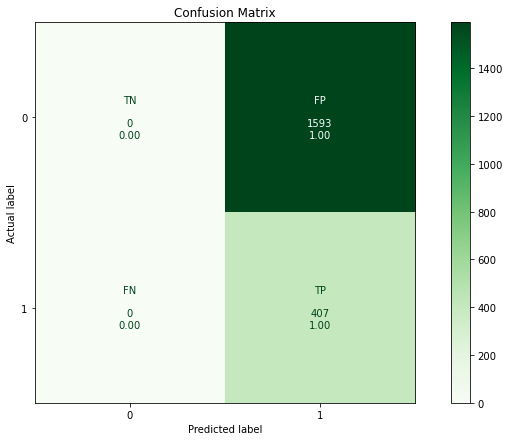

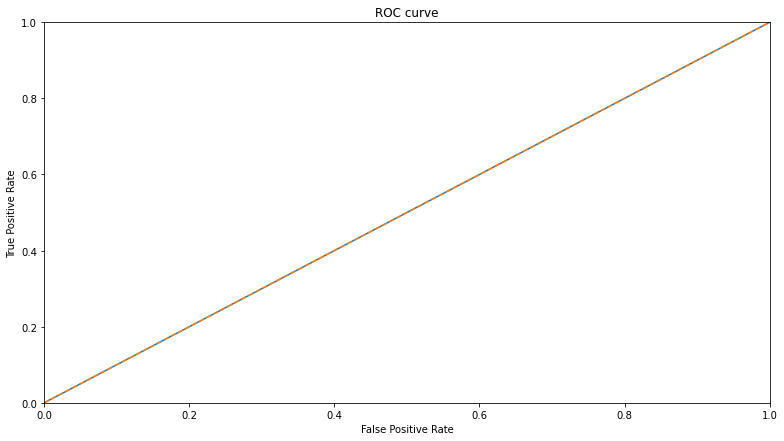

scores,train,test
accuracy,0.203750,0.20350
precision,0.203750,0.20350
recall,1.000000,1.00000
f1,0.338525,0.33818
roc_auc,0.500000,0.50000
matthews_corrcoef,0.000000,0.00000


In [121]:
hide_warnings(lambda:final_report(dummy, X_train, X_test, y_train, y_test))();

The ROC curve of the dummy model (Blue line) is exactly what's expected of a constant baseline model (Orange line),   
and as a result both lines overlap.

### Best model test scores
[up](#Models)

estimator:  RandomForestClassifier(max_depth=30, random_state=123)


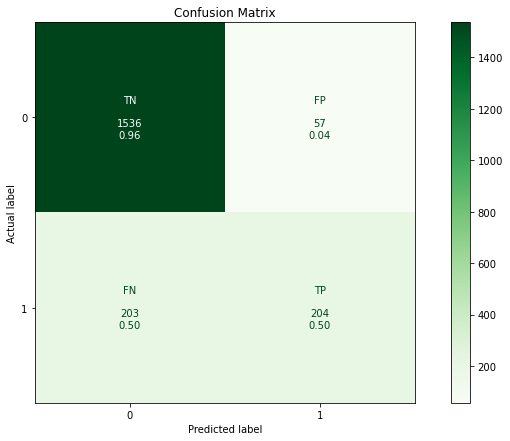

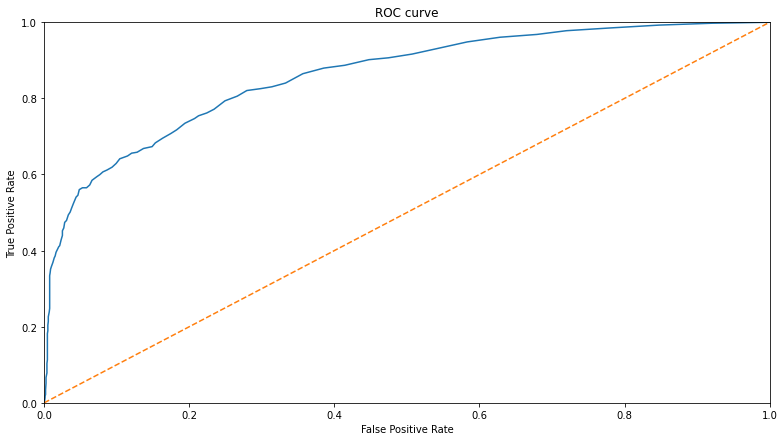

scores,train,test
accuracy,1.0,0.870000
precision,1.0,0.781609
recall,1.0,0.501229
f1,1.0,0.610778
roc_auc,1.0,0.859974
matthews_corrcoef,1.0,0.556295


In [122]:
final_report(best_estimator, X_train, X_test, y_train, y_test);

The ROC curve of the selected model (Blue curved line) is skewed towards TPR,  
Our model is doing significantly better than baseline,  
but the other metrics indicate that it is still not production ready:  
recall and precision are sub-optimal.

Also the test scores are lower than train scores, which means the model is overfit (possibly due to upsampling).

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Ok, great, you evaluated the final model on the test set and compared it to a dummy model. One problem: while the ROC curve is plotted correctly, ROC-AUC is again calculated incorrectly (using binary predictions rather than probabilities)

</div>

<div class="alert alert-info">
<b>Student's comment v.1:</b><br>
updated.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
Very good!
  
</div>

<br>

## Conclusions
***
[back](#Table-of-Contents)

We have processed the dataset (of 10,000 samples), adjusted it for consumption and accounted for target class imbalance.  
Random Forest Classifier was the most promising model, but the data was insufficient to make it 'good enough'.  
More data should be gathered, and then the model may become production ready.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Not sure what you mean by good enough, but your model passes the project's requirements :)

<div class="alert alert-info">
<b>Student's comment v.1:</b><br>
Depending on our business requirements, and the domain in which this ML model will be applied in, <br>
there may be a change in the 'acceptable' amount of False positives or False negatives.  <br>
For our specific use case, it is up to our client ("Beta Bank") to decide what is the acceptable threshold.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
  
Yes, you are right, of course!
  
</div>

<div class="alert alert-info">
<b>Student's comment v.2:</b><br>
Another thing I forgot to mention, is that since we have little data to work with, <br>
to gain a (possible) slight improvement in model performance, <br>
we could train the model on the entire preprocessed dataset after the final testing is done, <br>
and before the model is exported for production use.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V3</b>
  
Yeah, that's definitely something worth doing!
  
</div>